## Measuring Multimode Char Func

In [1]:
# define Operators

using QuantumOptics

const N = 50 # Cavity Dimension

# Cavity Operators
fb = FockBasis(N-1)

a = destroy(fb)
at = create(fb)
Ic = identityoperator(fb)

tlb = SpinBasis(1//2)
Iq = identityoperator(tlb)
sz = sigmaz(tlb)
sx = sigmax(tlb)
sy = sigmay(tlb)

g = spindown(tlb)

Ket(dim=2)
  basis: Spin(1/2)
 0.0 + 0.0im
 1.0 + 0.0im

### Single Mode Case

In [2]:
# States 
vacuum = fockstate(fb, 0)
coh1 = coherentstate(fb, im*1.0)
cat1 = (coherentstate(fb, 1.8) - coherentstate(fb, -1.8))/sqrt(2);

### Operator Based

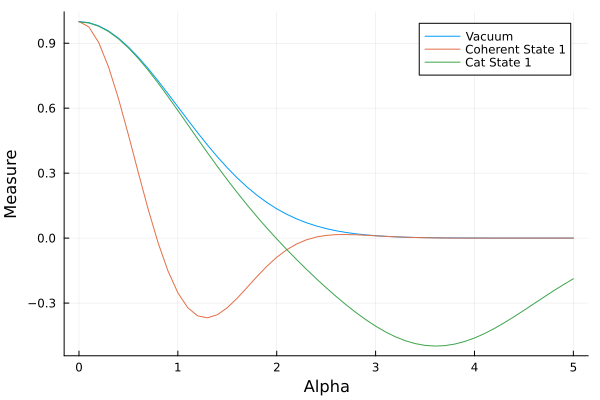

In [3]:
# States 
function measure_char_func_point(state,fb,α,real)
    if real
        return (expect(displace(fb,α),state)).re
    else
        return (expect(displace(fb,α),state)).im
    end
end

using Plots

alpha_values = 0:0.1:5

measure_vacuum = [measure_char_func_point(vacuum, fb, alpha, true) for alpha in alpha_values]
measure_coh1 = [measure_char_func_point(coh1, fb, alpha, true) for alpha in alpha_values]
measure_cat1 = [measure_char_func_point(cat1, fb, alpha, true) for alpha in alpha_values]

plot(alpha_values, measure_vacuum, label="Vacuum", xlabel="Alpha", ylabel="Measure")
plot!(alpha_values, measure_coh1, label="Coherent State 1")
plot!(alpha_values, measure_cat1, label="Cat State 1")

# using Plots

# alpha_values = 0:0.1:5
# measure_values = [measure_char_func_point(vacuum, fb, alpha, true) for alpha in alpha_values]

# plot(alpha_values, measure_values, xlabel="Alpha", ylabel="Measure", title="Measure vs Alpha")


### Evolution based

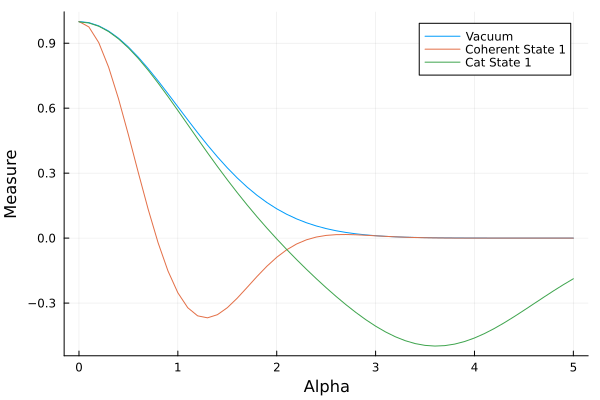

In [22]:
function H_CD_ge(α)
    sz⊗(a*conj(α)+at*α)
end
function CD_ge_evolution(α ,t , state)
        # final conditinal displacement beta given by β*max(t)
        H_total = H_CD_ge(α) 
        tout, ψt = timeevolution.schroedinger(t, state, H_total)
        last(ψt)
 
end

function H_qubit_drive_ge(δ, θ = 0)
    # θ = 0 -> rotate around x axis
    # θ = pi/2 -> rotate around y axis 
    # pi flip if ϵ*T_max = pi
    δ/2*(cos(θ)*sx + sin(θ)*sy)
end

function R_evolution_ge(δ, t,  state, θ = 0)
    H_total = H_qubit_drive_ge(δ, θ) ⊗ Ic 
    tout, ψt = timeevolution.schroedinger(t, state, H_total);
    last(ψt)
end

function measure_char_func_point_evolution(ψ0, is_real, α, t_list_rotation, t_list_conditinal_displacement)

    ψ1 = R_evolution_ge(π/2/(last(t_list_rotation)), t_list_rotation, ψ0)

    ψ2 = CD_ge_evolution(α/2*(1/last(t_list_conditinal_displacement)), t_list_conditinal_displacement, ψ1)

    if is_real # measure imaginary part
        ψ3 = R_evolution_ge(π/2/(last(t_list_rotation)), t_list_rotation, ψ2, 0)
    else # measure real part
        ψ3 = R_evolution_ge(π/2/(last(t_list_rotation)), t_list_rotation, ψ2, π/2)
    end
    return (expect(sz ⊗ Ic ,ψ3)).re
end
t_list_rotation = [0:0.01:0.05;]
t_list_conditinal_displacement = [0:0.1:0.6;]

alpha_values = 0:0.1:5

measure_vacuum = [measure_char_func_point_evolution(g ⊗ vacuum, true, alpha*im, t_list_rotation, t_list_conditinal_displacement) for alpha in alpha_values]
measure_coh1 = [measure_char_func_point_evolution(g ⊗ coh1, true, alpha*im, t_list_rotation, t_list_conditinal_displacement) for alpha in alpha_values]
measure_cat1 = [measure_char_func_point_evolution(g ⊗ cat1, true, alpha*im, t_list_rotation, t_list_conditinal_displacement) for alpha in alpha_values]

plot(alpha_values, measure_vacuum, label="Vacuum", xlabel="Alpha", ylabel="Measure")
plot!(alpha_values, measure_coh1, label="Coherent State 1")
plot!(alpha_values, measure_cat1, label="Cat State 1")

I learn the following from the above simulation.
- If i want to probe the point D(alpha) through evolution, then I have to displace the conditional displacement along im*alpha/2 (note the factor 2 is inside the function) 

## Two Mode Case

In [36]:
# States 
vacuum = fockstate(fb, 0) ⊗ fockstate(fb, 0)
coh1_coh1 = coherentstate(fb, im*1.0) ⊗ coherentstate(fb, im*1.0);
GHZ = (coherentstate(fb, 1.8) ⊗ coherentstate(fb, 1.8) +  coherentstate(fb, -1.8) ⊗ coherentstate(fb, -1.8))/sqrt(2);

### Operator Based

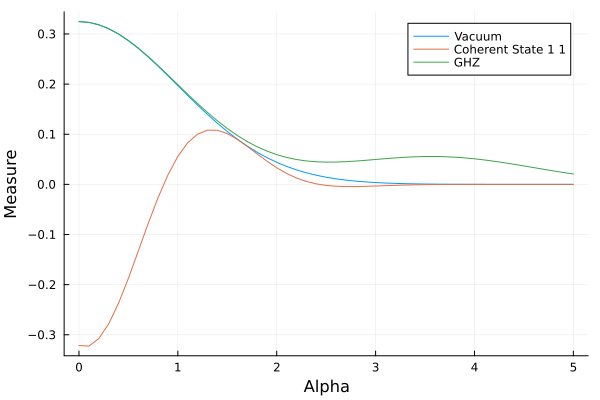

In [42]:
# States 
function measure_char_func_point_two_mode(state,fb,α,β,real)
    if real
        return (expect(displace(fb,α) ⊗ displace(fb,β),state)).re
    else
        return (expect(displace(fb,α) ⊗ displace(fb,β),state)).im
    end
end

using Plots

alpha_values = 0:0.1:5
beta = 1.5

measure_vacuum = [measure_char_func_point_two_mode(vacuum, fb, alpha,beta, true) for alpha in alpha_values]
measure_coh1 = [measure_char_func_point_two_mode(coh1_coh1, fb, alpha, beta, true) for alpha in alpha_values]
measure_GHZ = [measure_char_func_point_two_mode(GHZ, fb, alpha, beta, true) for alpha in alpha_values]


plot(alpha_values, measure_vacuum, label="Vacuum", xlabel="Alpha", ylabel="Measure")
plot!(alpha_values, measure_coh1, label="Coherent State 1 1")
plot!(alpha_values, measure_GHZ, label="GHZ")



### Evolution Based


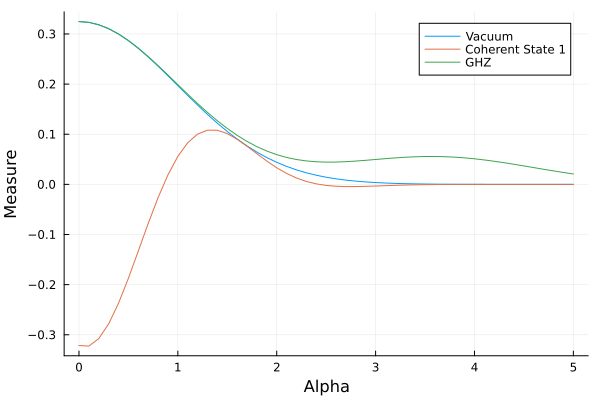

In [44]:
function H_CD_ge_2mode(α,β)
    sz⊗ ((a*conj(α)+at*α) ⊗ Ic + Ic ⊗ (a*conj(β)+at*β))
end

function CD_ge_evolution_2mode(α , β ,t , state)
        # final conditinal displacement beta given by β*max(t)
        H_total = H_CD_ge_2mode(α,β) 
        tout, ψt = timeevolution.schroedinger(t, state, H_total)
        last(ψt)
 
end

function H_qubit_drive_ge_2mode(δ, θ = 0)
    # θ = 0 -> rotate around x axis
    # θ = pi/2 -> rotate around y axis 
    # pi flip if ϵ*T_max = pi
    δ/2*(cos(θ)*sx + sin(θ)*sy)
end

function R_evolution_ge_2mode(δ, t,  state, θ = 0)
    H_total = H_qubit_drive_ge_2mode(δ, θ) ⊗ Ic  ⊗ Ic
    tout, ψt = timeevolution.schroedinger(t, state, H_total);
    last(ψt)
end

function measure_char_func_point_evolution_2mode(ψ0, is_real, α, β, t_list_rotation, t_list_conditinal_displacement)

    ψ1 = R_evolution_ge_2mode(π/2/(last(t_list_rotation)), t_list_rotation, ψ0)

    ψ2 = CD_ge_evolution_2mode(α/2*(1/last(t_list_conditinal_displacement)), β/2*(1/last(t_list_conditinal_displacement)), t_list_conditinal_displacement, ψ1)

    if is_real # measure imaginary part
        ψ3 = R_evolution_ge_2mode(π/2/(last(t_list_rotation)), t_list_rotation, ψ2, 0)
    else # measure real part
        ψ3 = R_evolution_ge_2mode(π/2/(last(t_list_rotation)), t_list_rotation, ψ2, π/2)
    end
    return (expect(sz ⊗ Ic ⊗ Ic ,ψ3)).re
end
t_list_rotation = [0:0.01:0.05;]
t_list_conditinal_displacement = [0:0.1:0.6;]

alpha_values = 0:0.1:5
beta = 1.5

measure_vacuum = [measure_char_func_point_evolution_2mode(g ⊗ vacuum, true, alpha*im, beta*im, t_list_rotation, t_list_conditinal_displacement) for alpha in alpha_values]
measure_coh1 = [measure_char_func_point_evolution_2mode(g ⊗ coh1_coh1, true, alpha*im, beta*im, t_list_rotation, t_list_conditinal_displacement) for alpha in alpha_values]
measure_GHZ = [measure_char_func_point_evolution_2mode(g ⊗ GHZ, true, alpha*im, beta*im, t_list_rotation, t_list_conditinal_displacement) for alpha in alpha_values]

plot(alpha_values, measure_vacuum, label="Vacuum", xlabel="Alpha", ylabel="Measure")
plot!(alpha_values, measure_coh1, label="Coherent State 1")
plot!(alpha_values, measure_GHZ, label="GHZ")


In [17]:
using QuantumOptics

const N = 15 # Cavity Dimension

# Cavity Operators
fb = FockBasis(N-1)

a = destroy(fb)
at = create(fb)
Ic = identityoperator(fb)

# qutrit operators
qb = FockBasis(3-1)

Iq = identityoperator(qb)
q = destroy(qb)
qt = create(qb)
sz_ge = Operator(qb,qb, [-1 0 0; 0 1 0; 0 0 1])
sz_gf = Operator(qb,qb, [-1 0 0; 0 0 0; 0 0 1])
sy_ge = Operator(qb,qb, [0 -1im 0; 1im 0 0; 0 0 1])
sy_ef = Operator(qb,qb, [1 0 0; 0 0 -1im; 0 1im 0])
sx_ge = Operator(qb,qb, [0 1 0; 1 0 0; 0 0 1])
sx_ef = Operator(qb,qb, [1 0 0; 0 0 1; 0 1 0])


tlb = SpinBasis(1//2)
I2 = identityoperator(tlb)
sz = sigmaz(tlb)
sx = sigmax(tlb)
sy = sigmay(tlb)

g = spindown(tlb)


# g = fockstate(qb,0)
# e = fockstate(qb,1)
# f = fockstate(qb,2)
# ge = 1/√2*(g+e)
# vac = fockstate(fb,0) 
# proj_g = projector(g) ⊗ Ic ⊗ Ic ⊗ Ic
# proj_e = projector(e) ⊗ Ic ⊗ Ic ⊗ Ic
# proj_f = projector(f) ⊗ Ic ⊗ Ic ⊗ Ic

# gvvv = g ⊗ vac ⊗ vac ⊗ vac
# evvv = e ⊗ vac ⊗ vac ⊗ vac
# gevvv = ((g+e)/√2) ⊗ vac ⊗ vac ⊗ vac
# gfvvv = ((g+f)/√2) ⊗ vac ⊗ vac ⊗ vac


Ket(dim=2)
  basis: Spin(1/2)
 0.0 + 0.0im
 1.0 + 0.0im

In [18]:
# Theory definition

function three_mode_char_func_point(state, fb, displacement_list)
    return expect(displace(fb, displacement_list[1]) ⊗ displace(fb, displacement_list[2]) ⊗ displace(fb, displacement_list[3]), state)
end

three_mode_char_func_point (generic function with 1 method)

In [21]:
# Protocol
function H_CD_ge(α)
    sz⊗(a*conj(α)+at*α)

function CD_ge_evolution(α ,t , state)
        # final conditinal displacement beta given by β*max(t)
        H_total = H_CD_ge(α) 
        tout, ψt = timeevolution.schroedinger(t, state, H_total)
        last(ψt)
    end
end

function H_triple_CD_ge(α,β,γ)
    sz⊗(a⊗Ic⊗Ic*conj(α)+at⊗Ic⊗Ic*α + Ic⊗a⊗Ic*conj(β)+Ic⊗at⊗Ic*β + Ic⊗Ic⊗a*conj(γ)+Ic⊗Ic⊗at*γ)
end

function triple_CD_ge_evolution(β ,t , state)
    # final conditinal displacement beta given by β*max(t)
    H_total = H_triple_CD_ge(β[1],β[2],β[3]) 
    tout, ψt = timeevolution.schroedinger(t, state, H_total)
    last(ψt)
end

function H_qubit_drive_ge(δ, θ = 0)
    # θ = 0 -> rotate around x axis
    # θ = pi/2 -> rotate around y axis 
    # pi flip if ϵ*T_max = pi
    δ/2*(cos(θ)*sx + sin(θ)*sy)
end

function R_evolution_ge(δ, t,  state, θ = 0)
    H_total = H_qubit_drive_ge(δ, θ) ⊗ Ic ⊗ Ic ⊗ Ic
    tout, ψt = timeevolution.schroedinger(t, state, H_total);
    last(ψt)
end

function R_evolution_ge_3(δ, t,  state, θ = 0)
    H_total = H_qubit_drive_ge(δ, θ) ⊗ Ic ⊗ Ic ⊗ Ic
    tout, ψt = timeevolution.schroedinger(t, state, H_total);
    last(ψt)
end





function measure_3Mode_char_point(ψ0, is_imag, displacement_list, t_list_rotation, t_list_conditinal_displacement)
    "is_imag_list: if sum is odd, then the final rotation is around x axis, and we measure the imaginary part of the char function. Otherwise, we measure the real part with a y rotation
    displacement_list: this is the actual value of alpha, -alpha -> implementing waht we understand under an ECD(2alpha) Thats why I divide in the beginning."
    displacement_list = displacement_list./2
    ψ1 = R_evolution_ge(π/2/(last(t_list_rotation)), t_list_rotation, ψ0)
    ψ2 = triple_CD_ge_evolution(displacement_list.*(1/last(t_list_conditinal_displacement)), t_list_conditinal_displacement, ψ1)
    if is_imag # measure imaginary part
        ψ3 = R_evolution_ge(π/2/(last(t_list_rotation)), t_list_rotation, ψ2, π/2)
    else # measure real part
        ψ3 = R_evolution_ge(π/2/(last(t_list_rotation)), t_list_rotation, ψ2, 0)
    end

    return real(expect(sz ⊗ Ic ⊗ Ic ⊗ Ic,ψ3)), [ψ1, ψ2, ψ3]
end

measure_3Mode_char_point (generic function with 1 method)

In [22]:
state = coherentstate(fb, 1.0) ⊗ coherentstate(fb, 1.0) ⊗ coherentstate(fb, 1.0)
result_theo = three_mode_char_func_point(state, fb, [1.0, 0.0, 0.0])
println(result_theo)

0.6065306587539878 + 0.0im


In [ ]:
t_list_rotation = [0:0.01:0.05;]
t_list_conditinal_displacement = [0:0.1:0.6;]
displacement_list = [1.0, 0.0, 0.0]

evolution_result, states = measure_3Mode_char_point(g ⊗ state, false, displacement_list, t_list_rotation, t_list_conditinal_displacement)
println(evolution_result)

In [14]:
t_list_rotation = [0:0.01:0.05;]
t_list_conditinal_displacement = [0:0.1:0.6;]
displacement_list = [1.0, 0.0, 0.0]

evolution_result, states = measure_3Mode_char_point(g ⊗ state, false, displacement_list, t_list_rotation, t_list_conditinal_displacement)
println(evolution_result)

-0.2524055497486671


In [14]:
ptrace(states[1],[2,3,4])

Operator(dim=3x3)
  basis: Fock(cutoff=2)
 0.5+0.0im  0.0+0.5im  0.0+0.0im
 0.0-0.5im  0.5+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im